### Description of the experiment  
Here is a table where the numeric variable is continuous.  
The task is to compare groups in two ways: bootstrap and u-test

Description of columns  
value – metric values  
experimentVariant – Test variant (Control – control group, Treatment – test group)  

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
df = pd.read_csv('hw_bootstrap.csv', sep=';', decimal=',')

In [3]:
df.drop(columns='Unnamed: 0', axis=1, inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   value              1000 non-null   float64
 1   experimentVariant  1000 non-null   object 
dtypes: float64(1), object(1)
memory usage: 15.8+ KB


In [5]:
df

,value,experimentVariant
0,10.380495,Control
1,9.546867,Control
2,11.088215,Control
3,10.147274,Control
4,9.789808,Control
...,...,...
995,1000.000000,Treatment
996,1200.000000,Treatment
997,1500.000000,Treatment
998,2000.000000,Treatment


In [6]:
df.groupby('experimentVariant', as_index=False).agg({'value': 'count'})

,experimentVariant,value
0,Control,500
1,Treatment,500


In [7]:
df.groupby('experimentVariant', as_index=False).agg({'value': 'mean'})

,experimentVariant,value
0,Control,10.026867
1,Treatment,27.321499


In [8]:
df.groupby('experimentVariant', as_index=False).agg({'value': 'median'})

,experimentVariant,value
0,Control,10.018465
1,Treatment,10.025847


In real life, this data would be worth checking and clearing outliers.

#### Apply bootstrap (with np.mean) and mann-whitney test and then compare p-value

In [9]:
# a function will allow us to test hypotheses using the bootstrap
def get_bootstrap(
    data_column_1, # numeric values of the first sample
    data_column_2, # numeric values of the second sample
    boot_it = 1000, # number of bootstrap subsamples
    statistic = np.mean, # the statistics we are interested in
    bootstrap_conf_level = 0.95 # significance level
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # extract subsamples
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # return parameter
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - apply statistics
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Visualization
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=60,linestyle='--',colors='black')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

  0%|          | 0/5000 [00:00<?, ?it/s]

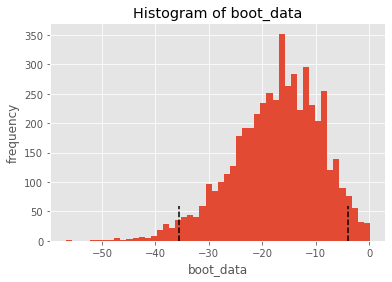

In [10]:
booted_data_mean = get_bootstrap(df.query('experimentVariant == "Control"').value, 
                                 df.query('experimentVariant == "Treatment"').value, boot_it = 5000)

In [11]:
# p_value for bootstrap
booted_data_mean['p_value']

0.03619718104182933

In [12]:
# p_value for mann-whitney
mannwhitneyu(df.query('experimentVariant == "Control"').value, df.query('experimentVariant == "Treatment"').value)[1]

0.8592148582485579

When using bootstrap, because p_value < 0.05 there are reasons to reject the null hypothesis about the equality of the means, but if the significance level were taken to be 0.01, then it would be impossible to reject the null hypothesis about the equality of the means. 

When applying mann-whitney, we can definitely say that there is no reason to reject the null hypothesis that the distributions of both groups do not differ, since p_value > 0.05

#### Let's apply the bootstrap (with np.median) and the mann-whitney test, and then compare the p-value.

  0%|          | 0/5000 [00:00<?, ?it/s]

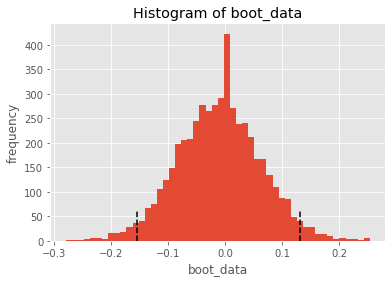

In [13]:
booted_data_median = get_bootstrap(df.query('experimentVariant == "Control"').value, 
                                   df.query('experimentVariant == "Treatment"').value, 
                                   boot_it = 5000, statistic = np.median)

In [14]:
# p_value for bootstrap
booted_data_median['p_value']

0.8824129320555123

In [15]:
# p_value for mann-whitney
mannwhitneyu(df.query('experimentVariant == "Control"').value, df.query('experimentVariant == "Treatment"').value)[1]

0.8592148582485579

In this case, the p_values of both criteria are almost the same and > 0.05, i.e. there is no reason to reject the null hypotheses that the medians and distributions of the groups are statistically significantly different.

Most likely, when applying the bootstrap with np.mean, p_value was affected by outliers in the Treatment group

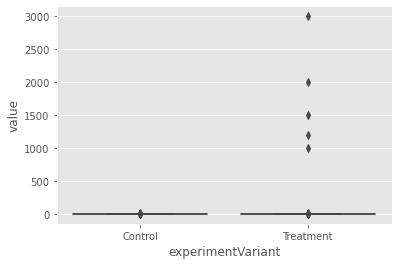

In [16]:
sns.boxplot(x="experimentVariant", y="value", data=df);

## Conclusions
* The test sample has large outliers, which greatly distorts the mean value for us.  
* Using a bootstrap with a mean estimate, we could reject the null hypothesis that the means are equal and conclude that the test and control samples have differences.  
* However, the same bootstrap, but already by the median, does not allow us to reject the null hypothesis, since the p-value is much greater than 0.05, because here another hypothesis is being tested.  
* The Mann-Whitney U test would also prevent us from rejecting the null hypothesis. The p-value estimates are just as directed as the median bootstrap.